# Fake News Detection

The topic of fake news detection on social media has recently attracted tremendous attention. The basic countermeasure of comparing websites against a list of labeled fake news sources is inflexible, and so a machine learning approach is desirable. Our project aims to use Natural Language Processing to detect fake news directly, based on the text content of news articles.

### Objective

Develop a machine learning program to identify when an article might be fake news.

### Dataset Description:

1. id: unique id for a news article
2. title: the title of a news article
3. author: author of the news article
4. text: the text of the article; could be incomplete
5. label: a label that marks whether the news article is real or fake:
    - Fake news - 1
    - Real News - 0

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [3]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Data Pre-processing

In [8]:
news_data = pd.read_csv('/Projects/Fake News Detection/Datasets/train.csv')
news_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [10]:
news_data.shape

(20800, 5)

In [11]:
news_data.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [13]:
# replacing the null values with empty string
news_data = news_data.fillna('')

In [14]:
news_data.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [16]:
# merging the author name and news title

news_data['content'] = news_data['author']+' '+news_data['title']

In [17]:
print(news_data['content'])

0        Darrell Lucus House Dem Aide: We Didn’t Even S...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
20795    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20796    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20797    Michael J. de la Merced and Rachel Abrams Macy...
20798    Alex Ansary NATO, Russia To Hold Parallel Exer...
20799              David Swanson What Keeps the F-35 Alive
Name: content, Length: 20800, dtype: object


In [18]:
# separating the data & label

## Get the Independent Features
X = news_data.drop(columns='label', axis=1)
## Get the Dependent features
Y = news_data['label']

In [19]:
Y.value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [20]:
print(X)
print(Y)

          id                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
20795  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiu

### Stemming

- A stemming algorithm is a process of linguistic normalisation, in which the variant forms of a word are reduced to a common form.
- In simple words, Stemming is the process of reducing a word to its Root word.

- EXAMPLES:
    - actor, actress, acting --> act
    - eating, eats, eaten --> eat

In [21]:
port_stem = PorterStemmer()

In [22]:
def stemming(content):
    review = re.sub('[^a-zA-Z]',' ',content)
    review = review.lower()
    review = review.split()
    review = [port_stem.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    return review

In [23]:
news_data['content'] = news_data['content'].apply(stemming)

In [24]:
print(news_data['content'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman n f l playoff schedul matchup...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799                            david swanson keep f aliv
Name: content, Length: 20800, dtype: object


In [25]:
#separating the data and label
X = news_data['content'].values
Y = news_data['label'].values

In [26]:
print(X)

['darrel lucu hous dem aid even see comey letter jason chaffetz tweet'
 'daniel j flynn flynn hillari clinton big woman campu breitbart'
 'consortiumnew com truth might get fire' ...
 'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time'
 'alex ansari nato russia hold parallel exercis balkan'
 'david swanson keep f aliv']


In [27]:
print(Y)

[1 0 1 ... 0 1 1]


In [29]:
Y.shape

(20800,)

### TF-IDF
TF-IDF stands for “Term Frequency – Inverse Document Frequency ”

- TF-IDF is a numerical statistic which measures the importance of the word in a document.

- Term Frequency : Number of time a word appears in a text document.

- Inverse Document Frequency : Measure the word is a rare word or common word in a document.

In [30]:
# converting the textual data to numerical data
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)

In [31]:
print(X)

  (0, 15686)	0.28485063562728646
  (0, 13473)	0.2565896679337957
  (0, 8909)	0.3635963806326075
  (0, 8630)	0.29212514087043684
  (0, 7692)	0.24785219520671603
  (0, 7005)	0.21874169089359144
  (0, 4973)	0.233316966909351
  (0, 3792)	0.2705332480845492
  (0, 3600)	0.3598939188262559
  (0, 2959)	0.2468450128533713
  (0, 2483)	0.3676519686797209
  (0, 267)	0.27010124977708766
  (1, 16799)	0.30071745655510157
  (1, 6816)	0.1904660198296849
  (1, 5503)	0.7143299355715573
  (1, 3568)	0.26373768806048464
  (1, 2813)	0.19094574062359204
  (1, 2223)	0.3827320386859759
  (1, 1894)	0.15521974226349364
  (1, 1497)	0.2939891562094648
  (2, 15611)	0.41544962664721613
  (2, 9620)	0.49351492943649944
  (2, 5968)	0.3474613386728292
  (2, 5389)	0.3866530551182615
  (2, 3103)	0.46097489583229645
  :	:
  (20797, 13122)	0.2482526352197606
  (20797, 12344)	0.27263457663336677
  (20797, 12138)	0.24778257724396507
  (20797, 10306)	0.08038079000566466
  (20797, 9588)	0.174553480255222
  (20797, 9518)	0.295420

In [33]:
# SPLITTING THE DATASET INTO TRAINING DATA & TEST DATA:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

### Training the Models:


#### Logistic Regression:

Logistic regression is a statistical analysis method to predict a binary outcome, such as yes or no, based on prior observations of a data set. A logistic regression model predicts a dependent data variable by analyzing the relationship between one or more existing independent variables.

In [34]:
model = LogisticRegression()

In [35]:
model.fit(X_train, Y_train)

LogisticRegression()

#### Evaluation

In [36]:
# accuracy score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [37]:
print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  0.9865985576923076


In [38]:
# accuracy score on the test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [39]:
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9790865384615385


### Building a predictive system

Building a predictive system inorder to find that the inital word in the dataset is real or fake using LogisticRegression model:

In [48]:
X_new = X_test[0]

prediction = model.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[1]
The news is Fake


In [49]:
print(Y_test[0])

1


### Confusion Matrix
The confusion matrix is a 2 dimensional array comparing predicted category labels to the true label.

In [40]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X, Y, test_size=0.33, random_state=42)

### CLASSIFICATION MODEL : MULTINOMIAL NAIVE BAYES

- Multinomial Naive Bayes algorithm is a probabilistic learning method that is mostly used in Natural Language Processing (NLP)

- Multinomial Naïve Bayes uses term frequency i.e. the number of times a given term appears in a document. Term frequency is often normalized by dividing the raw term frequency by the document length


In [43]:
#let's implement the model : Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()

accuracy:   0.950
Confusion matrix, without normalization


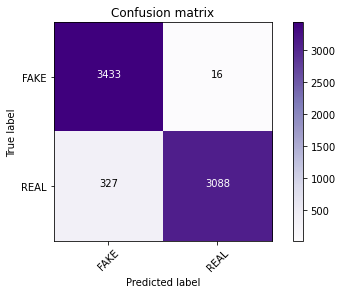

In [44]:
from sklearn import metrics
import numpy as np
import itertools

classifier.fit(X1_train, Y1_train)
prediction1 = classifier.predict(X1_test)
score = metrics.accuracy_score(Y1_test, prediction1)
print("accuracy:   %0.3f" % score)
cm1 = metrics.confusion_matrix(Y1_test, prediction1)
plot_confusion_matrix(cm1, classes=['FAKE', 'REAL'])

### Building a predictive system

Building a predictive system inorder to find that the inital word in the dataset is real or fake using Multinomial Naive Bayes model:



In [50]:
X1_new = X1_test[0]

prediction = model.predict(X1_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[1]
The news is Fake


In [51]:
print(Y1_test[0])

1


### CLASSIFICATION MODEL : PASSIVE AGGRESSIVE CLASSIFIER

- Passive Aggressive Classifier works by responding as passive for correct classifications and responding as aggressive for any miscalculation.

In [45]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X, Y, test_size=0.33, random_state=42)

accuracy:   0.990
Confusion matrix, without normalization


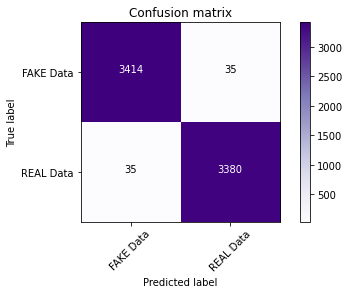

In [46]:
#lets implemet the algorithm : Passive Aggressive Classifier
from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier(max_iter=50)

linear_clf.fit(X2_train, Y2_train)
prediction2 = linear_clf.predict(X2_test)
score = metrics.accuracy_score(Y2_test, prediction2)
print("accuracy:   %0.3f" % score)
cm2 = metrics.confusion_matrix(Y2_test, prediction2)
plot_confusion_matrix(cm2, classes=['FAKE Data', 'REAL Data'])

### Building a predictive system

Building a predictive system inorder to find that the inital word in the dataset is real or fake using Passive Aggressive Classifier:

In [52]:
X2_new = X2_test[0]

prediction = model.predict(X2_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[1]
The news is Fake


In [53]:
print(Y2_test[0])

1


### Classification Report

- A Classification report is used to measure the quality of predictions from a classification algorithm.

- It is used to show the precision, recall, F1 Score, and support of your trained classification model.

In [54]:
# Logistic Regression

from sklearn.metrics import classification_report
print(classification_report(Y_test, X_test_prediction))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2077
           1       0.97      0.99      0.98      2083

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160



In [55]:
# Naive-Bayes Classifier

from sklearn.metrics import classification_report
print(classification_report(Y1_test,prediction1))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3449
           1       0.99      0.90      0.95      3415

    accuracy                           0.95      6864
   macro avg       0.95      0.95      0.95      6864
weighted avg       0.95      0.95      0.95      6864



In [56]:
# Passive-Aggressive Classifier

from sklearn.metrics import classification_report
print(classification_report(Y2_test,prediction2))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3449
           1       0.99      0.99      0.99      3415

    accuracy                           0.99      6864
   macro avg       0.99      0.99      0.99      6864
weighted avg       0.99      0.99      0.99      6864



### Model Comparision

Hence, in this dataset we can observe that

- Logistic Regression : Accuracy is 0.98

- Multinomial Naive Bayes : Accuracy is 0.95

- Passive Aggressive Classifier : Accuracy is 0.99